In [1]:
from google.colab import drive

drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import ndimage, signal, interpolate
import cv2
import random 

# 1.

In [21]:
def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

In [4]:
def gaussian_kernel(k=3, sig=1.):
    ax = np.linspace(-(k - 1) / 2., (k - 1) / 2., k)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)


def myFlow(img_1, img_2, window, T):
  u, v, validity_map = None, None, None
  # spatial and temporal derivatives
  k_x = (1/12) * np.array([[-1, 8, 0, -8, 1]])
  k_y = (1/12) * np.array([[-1], [8], [0], [-8], [1]])
  k_t = gaussian_kernel(3, 1.0)

  Ix = ndimage.convolve(img_1, k_x)
  Iy = ndimage.convolve(img_1, k_y)
  It = signal.convolve2d(img_2, k_t, mode='same') - signal.convolve2d(img_1, k_t, mode='same')

  # form matrix
  x, y = img_1.shape[0], img_1.shape[1]
  u = v = np.zeros((x, y))
  validity_map = np.ones((x, y))
  for i in range(window, x - window):
    for j in range(window, y - window):
      Ix_w = Ix[i - window: i + window + 1, j - window :j + window + 1].flatten()
      Iy_w = Iy[i - window: i + window + 1, j - window :j + window + 1].flatten()
      It_w = It[i - window: i + window + 1, j - window :j + window + 1].flatten()
      temp = np.array(np.matrix((Ix_w, Iy_w)))
      temp_t = temp.T
      A = np.dot(temp, temp_t)
      try:
        b = np.dot(np.linalg.pinv(A), temp)
        uv = np.dot(b,It_w)
        u[i][j], v[i][j] = uv[0], uv[1]
      except np.linalg.linalg.LinAlgError:
        u[i][j], v[i][j] = 0, 0
        validity_map[i][j] = 0
  return u, v, validity_map

It can be seen that in all examples, smaller window sizes resulted in capturing more subtle motions, whereas larger window sizes resulted in capturing large motions bwtween two frames.

## corridor image

In [ ]:
img_1 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/corridor/bt_0.png')
img_2 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/corridor/bt_1.png')

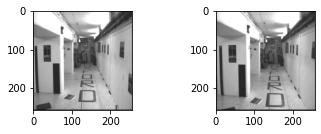

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(img_1, cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(img_2, cmap="gray")

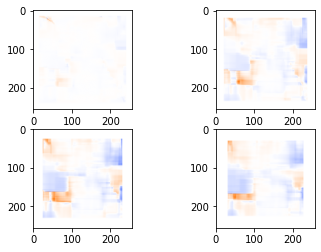

In [ ]:
u, v, v_map = myFlow(img_1, img_2, window=15, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 1)
plt.imshow(img_flow/img_flow.max(), cmap="gray")

u, v, v_map = myFlow(img_1, img_2, window=20, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 2)
plt.imshow(img_flow/img_flow.max(), cmap="gray")

u, v, v_map = myFlow(img_1, img_2, window=25, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 3)
plt.imshow(img_flow/img_flow.max(), cmap="gray")

u, v, v_map = myFlow(img_1, img_2, window=30, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 4)
plt.imshow(img_flow/img_flow.max(), cmap="gray")

## Sphere

In [ ]:
img_1 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/sphere/sphere_0.png')
img_2 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/sphere/sphere_1.png')

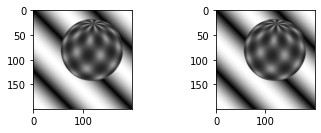

In [ ]:
gray_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
gray_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
plt.subplot(2, 2, 1)
plt.imshow(gray_img_1, cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(gray_img_2, cmap="gray")

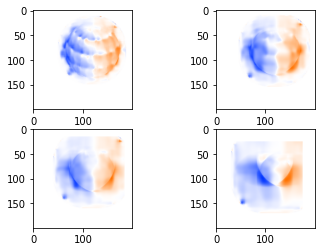

In [ ]:
u, v, v_map = myFlow(gray_img_1, gray_img_2, window=5, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 1)
plt.imshow(img_flow, cmap="gray")

u, v, v_map = myFlow(gray_img_1, gray_img_2, window=10, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 2)
plt.imshow(img_flow, cmap="gray")

u, v, v_map = myFlow(gray_img_1, gray_img_2, window=15, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 3)
plt.imshow(img_flow, cmap="gray")

u, v, v_map = myFlow(gray_img_1, gray_img_2, window=25, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 4)
plt.imshow(img_flow, cmap="gray")

## Synth

In [ ]:
img_1 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/synth/synth_0.png')
img_2 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/synth/synth_1.png')

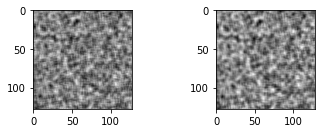

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(img_1, cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(img_2, cmap="gray")

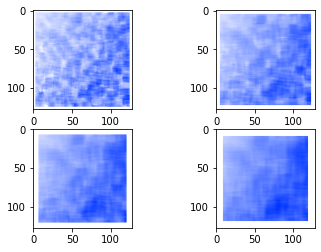

In [ ]:
u, v, v_map = myFlow(img_1, img_2, window=3, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 1)
plt.imshow(img_flow, cmap="gray")

u, v, v_map = myFlow(img_1, img_2, window=5, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 2)
plt.imshow(img_flow, cmap="gray")

u, v, v_map = myFlow(img_1, img_2, window=7, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 3)
plt.imshow(img_flow, cmap="gray")

u, v, v_map = myFlow(img_1, img_2, window=9, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 4)
plt.imshow(img_flow, cmap="gray")

# 2.

Not completed. Ran into an error in cv2.remap() that couldn't solve.

In [173]:
def myWarp(im_address, flow):
  import cv2
  im = cv2.imread(im_address)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  print(im.max())
  h, w = flow.shape[:2]
  flow = -flow
  flow[:,:,0] += np.arange(w)
  flow[:,:,1] += np.arange(h)[:,np.newaxis]
  flow.astype(np.float64)
  # temp = np.array([[0, 0], [0, 0]], dtype=np.float32)
  # print(im.shape)
  # cv2.resize(temp, im.shape)[im.shape[0]:0][im.shape[1]:0].astype('float32')
  prevImg = cv2.remap(im, flow, None, cv2.INTER_LINEAR)
  return prevImg

In [ ]:
img_1_warpped = myWarp('/content/MyDrive/MyDrive/Computer Vision/A4/Sequences/synth/synth_0.png', flow)
plt.imshow(img_1_warpped)

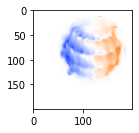

In [ ]:
u, v, v_map = myFlow(gray_img_1, gray_img_2, window=5, T=0.01)
flow = np.zeros((u.shape[0], u.shape[1], 2))
flow[:, :, 0] = u
flow[:, :, 1] = v
img_flow = flowToColor(flow)
plt.subplot(2, 2, 1)
plt.imshow(img_flow/img_flow.max(), cmap="gray")

# 3.

In [5]:
img_h_1 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Hotel Sequence/hotel.seq0.png')
img_h_2 = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Hotel Sequence/hotel.seq1.png')

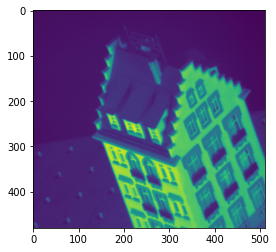

In [6]:
plt.imshow(img_h_1)

## Find good features to track

In [7]:
def HarrisCorner(img, thresh):
  k_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype="int32")
  img_cpy = img.copy()
  Ix = ndimage.convolve(img_cpy, k_x)
  Iy = ndimage.convolve(img_cpy, k_x.T)

  sigma = 5
  g = gaussian_kernel(k=2*5*3+1, sig=sigma)
  Ix_2 = ndimage.convolve(np.square(Ix), g)
  Iy_2 = ndimage.convolve(np.square(Iy), g)
  Ixy = ndimage.convolve(Ix * Iy, g)

  k = 0.04
  r = (Ix_2 * Iy_2 - np.square(Ixy)) - k *  np.square(Ix_2 + Iy_2)
  r = (r - r.min()) / (r.max() - r.min())
  locs = np.where(r >= thresh)
  for pt in zip(*locs[::-1]):
    cv2.circle(img_cpy, pt, 3, (0, 0, 1), -1)
  return img_cpy, locs

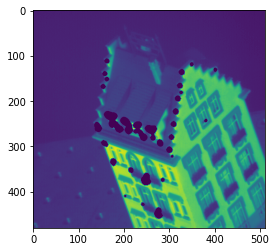

In [8]:
img_featureed, locs = HarrisCorner(img_h_1, 0.35)
plt.imshow(img_featureed)

## Frame to Frame Feature displacement

In [123]:
def myKLTFlow(img_1, img_2, keypoints_new_x, keypoints_new_y, T, window=15):
  u, v, validity_map = None, None, None
  movedOutFlag = np.zeros((keypoints_new_x.shape[0], 1))
  # spatial and temporal derivatives
  k_x = (1/12) * np.array([[-1, 8, 0, -8, 1]])
  k_y = (1/12) * np.array([[-1], [8], [0], [-8], [1]])
  k_t = gaussian_kernel(3, 1.0)

  Ix = ndimage.convolve(img_1, k_x)
  Iy = ndimage.convolve(img_1, k_y)
  It = signal.convolve2d(img_2, k_t, mode='same') - signal.convolve2d(img_1, k_t, mode='same')

  # random indices
  kp_translated_x = keypoints_new_x.copy()
  kp_translated_y = keypoints_new_y.copy()

  # form matrix
  x, y = img_1.shape[0], img_1.shape[1]
  u = v = np.zeros((x, y))
  validity_map = np.ones((x, y))
  for ii in range(len(keypoints_new_x)):
    if movedOutFlag[ii, 0] == 0:
      i = keypoints_new_x[ii]
      j = keypoints_new_y[ii]
      Ix_w = Ix[i - window: i + window + 1, j - window :j + window + 1].flatten()
      Iy_w = Iy[i - window: i + window + 1, j - window :j + window + 1].flatten()
      It_w = It[i - window: i + window + 1, j - window :j + window + 1].flatten()
      temp = np.array(np.matrix((Ix_w, Iy_w)))
      temp_t = temp.T
      A = np.dot(temp, temp_t)
      try:
        b = np.dot(np.linalg.pinv(A), temp)
        uv = np.dot(b,It_w)
        u[i][j], v[i][j] = uv[0], uv[1]
      except np.linalg.linalg.LinAlgError:
        u[i][j], v[i][j] = 0, 0
        validity_map[i][j] = 0
      kp_translated_x[ii], kp_translated_y[ii] = kp_translated_x[ii] - u[i][j], kp_translated_y[ii] - v[i][j]
      if kp_translated_x[ii] >= img_1.shape[0] or kp_translated_x[ii] < 0 or kp_translated_y[ii] >= img_1.shape[1] or kp_translated_y[ii] < 0:
        movedOutFlag[ii, 0] = 1
  return u, v, movedOutFlag, kp_translated_x, kp_translated_y

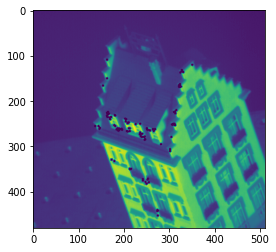

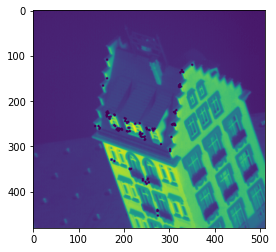

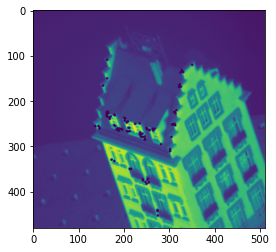

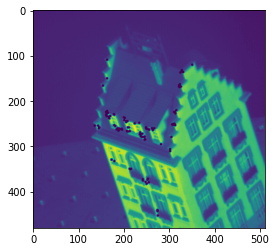

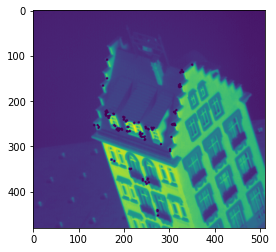

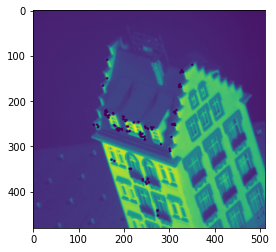

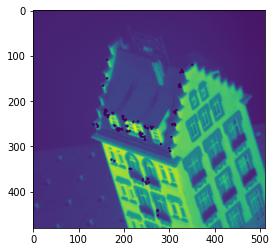

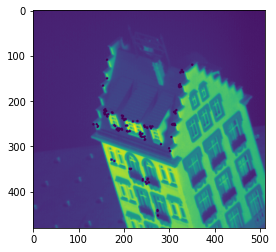

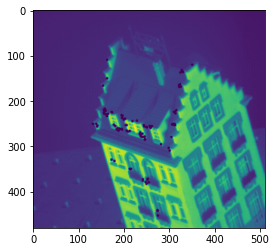

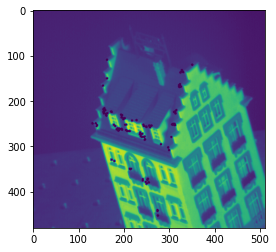

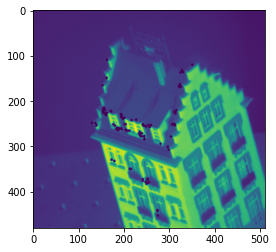

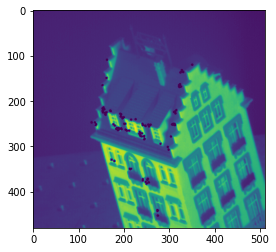

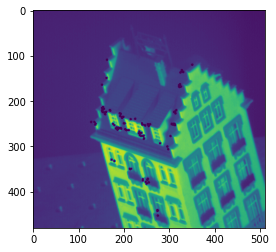

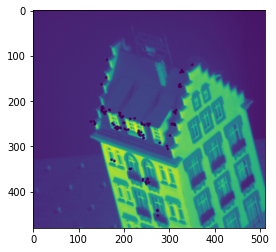

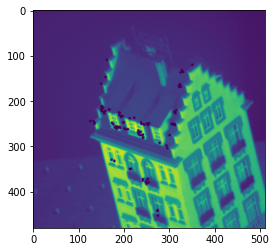

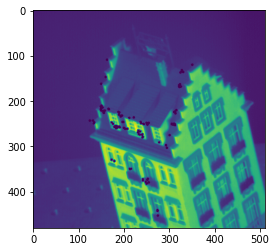

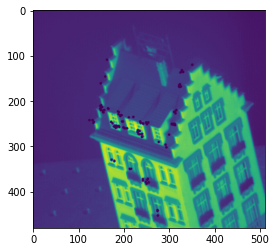

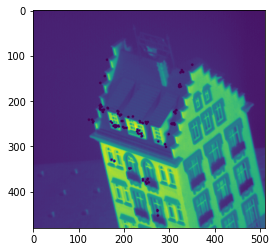

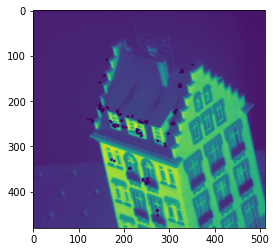

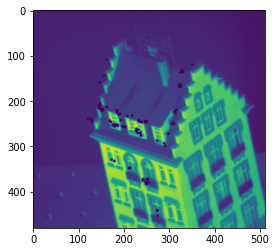

In [126]:
from PIL import Image

images = []
for i in range(50):
  img = plt.imread('/content/MyDrive/MyDrive/Computer Vision/A4/Hotel Sequence/hotel.seq' + str(i) + '.png')
  images.append(img)

img_featureed, locs = HarrisCorner(images[0], 0.35)
indices = random.sample(range(1, locs[0].shape[0]), 100)
keypoints_new_x = locs[0][indices]
keypoints_new_y = locs[1][indices]
u, v, movedOutFlag, kp_translated_x, kp_translated_y = myKLTFlow(images[0], images[1], keypoints_new_x, keypoints_new_y, T=0.01)

for i in range(1, 49):
  movedOut = np.where(movedOutFlag == 1)[0]
  kp_translated_x = np.delete(kp_translated_x, movedOut)
  kp_translated_y = np.delete(kp_translated_y, movedOut)
  u, v, movedOutFlag, kp_translated_x, kp_translated_y = myKLTFlow(images[i], images[i+1], kp_translated_x, kp_translated_y, T=0.01)
  if i <= 20:
    img_cpy = images[i].copy()
    for pt in zip(*(kp_translated_y, kp_translated_x)):
      img_cpy = cv2.circle(img_cpy, pt, 3, (0, 255, 0), -1)
    plt.imshow(img_cpy)
    plt.show()

No key point have moved out of the frame.

In [129]:
movedOut = np.where(movedOutFlag == 1)[0]
movedOut

array([], dtype=int64)